In [32]:
import zipfile
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

!wget https://github.com/kekonline/My-First-TF-CNN/raw/master/Data.zip

zip_ref = zipfile.ZipFile("Data.zip", "r")
zip_ref.extractall()
zip_ref.close()

data_dir = pathlib.Path("Data/Train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)


--2024-01-07 16:37:59--  https://github.com/kekonline/My-First-TF-CNN/raw/master/Data.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kekonline/My-First-TF-CNN/master/Data.zip [following]
--2024-01-07 16:37:59--  https://raw.githubusercontent.com/kekonline/My-First-TF-CNN/master/Data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5350733 (5.1M) [application/zip]
Saving to: ‘Data.zip.4’

Data.zip.4          100%[===================>]   5.10M  --.-KB/s    in 0.02s   

2024-01-07 16:37:59 (212 MB/s) - ‘Data.zip.4’ saved [5350733/5350733]

['Book' 'Game']


In [15]:
def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

In [29]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [36]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

Image shape: (1512, 2016, 3)
Image shape: (2016, 1512, 3)


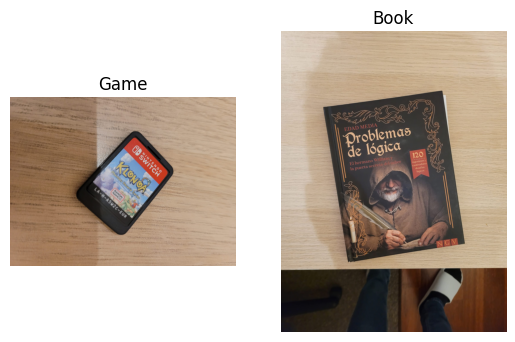

In [30]:
plt.figure()
plt.subplot(1, 2, 1)
steak_img = view_random_image("Data/Train/", "Game")
plt.subplot(1, 2, 2)
book_img = view_random_image("Data/Train/", "Book")

In [28]:
# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "Data/Train/"
test_dir = "Data/Test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10,
                         kernel_size=3, # can also be (3, 3)
                         activation="relu",
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output
])

# Compile the model
model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Found 16 images belonging to 2 classes.
Found 4 images belonging to 2 classes.
Epoch 1/5
1/1 [==============================] - 7s 7s/step - loss: 0.6956 - accuracy: 0.4375 - val_loss: 0.6266 - val_accuracy: 0.5000
Epoch 2/5
1/1 [==============================] - 1s 687ms/step - loss: 0.6372 - accuracy: 0.5000 - val_loss: 0.5992 - val_accuracy: 1.0000
Epoch 3/5
1/1 [==============================] - 1s 883ms/step - loss: 0.5690 - accuracy: 0.8750 - val_loss: 0.5676 - val_accuracy: 1.0000
Epoch 4/5
1/1 [==============================] - 1s 1s/step - loss: 0.5126 - accuracy: 0.9375 - val_loss: 0.5061 - val_accuracy: 1.0000
Epoch 5/5
1/1 [==============================] - 1s 774ms/step - loss: 0.4423 - accuracy: 0.9375 - val_loss: 0.4404 - val_accuracy: 1.0000


In [39]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 10)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                   

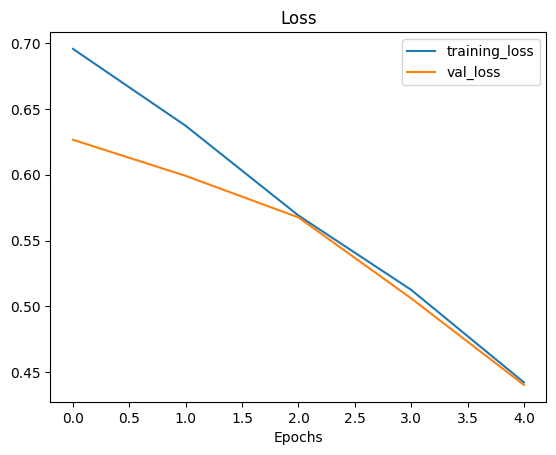

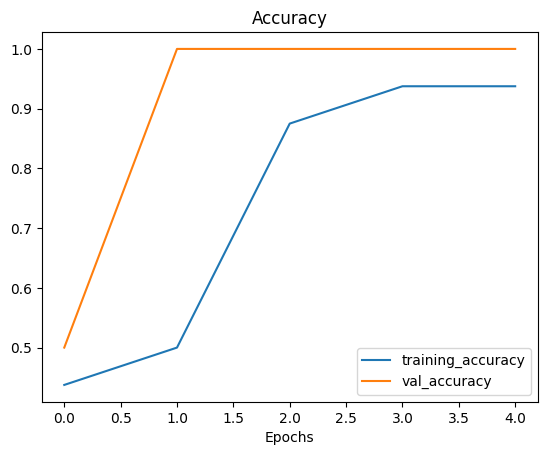

In [37]:
plot_loss_curves(history_1)

In [40]:
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [41]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

--2024-01-07 16:51:15--  https://www.ballpublishing.com/images/HardcoverRedBook.jpg
Resolving www.ballpublishing.com (www.ballpublishing.com)... 20.236.108.89
Connecting to www.ballpublishing.com (www.ballpublishing.com)|20.236.108.89|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 433307 (423K) [image/jpeg]
Saving to: ‘HardcoverRedBook.jpg’

HardcoverRedBook.jp 100%[===================>] 423.15K   680KB/s    in 0.6s    

2024-01-07 16:51:17 (680 KB/s) - ‘HardcoverRedBook.jpg’ saved [433307/433307]

1/1 [==============================] - 0s 27ms/step


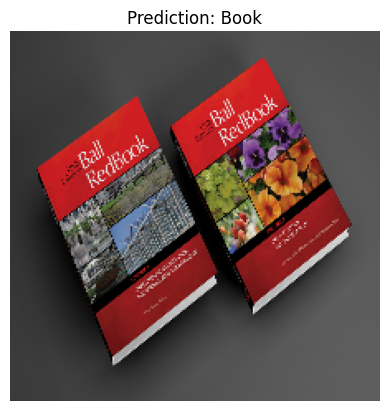

In [45]:
!wget https://www.ballpublishing.com/images/HardcoverRedBook.jpg
pred_and_plot(model_1, "HardcoverRedBook.jpg", class_names)